# Wine Quality Prediction

# Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import jarque_bera, normaltest, shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance
import joblib
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Data Loading and Initial Exploration

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
print(f"Dataset Shape: {data.shape}")
print(f"Features: {list(data.columns)}")
print(f"Target Distribution:\n{data['quality'].value_counts().sort_index()}")

Dataset Shape: (1599, 12)
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
Target Distribution:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


# Data Quality Assessment

In [3]:
missing_data = data.isnull().sum()
duplicate_rows = data.duplicated().sum()
data_types = data.dtypes
print(f"Missing Values:\n{missing_data}")
print(f"Duplicate Rows: {duplicate_rows}")
print(f"Data Types:\n{data_types}")
basic_stats = data.describe()
print(f"Basic Statistics:\n{basic_stats}")

Missing Values:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Duplicate Rows: 240
Data Types:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object
Basic Statistics:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806  

# Target Variable Analysis

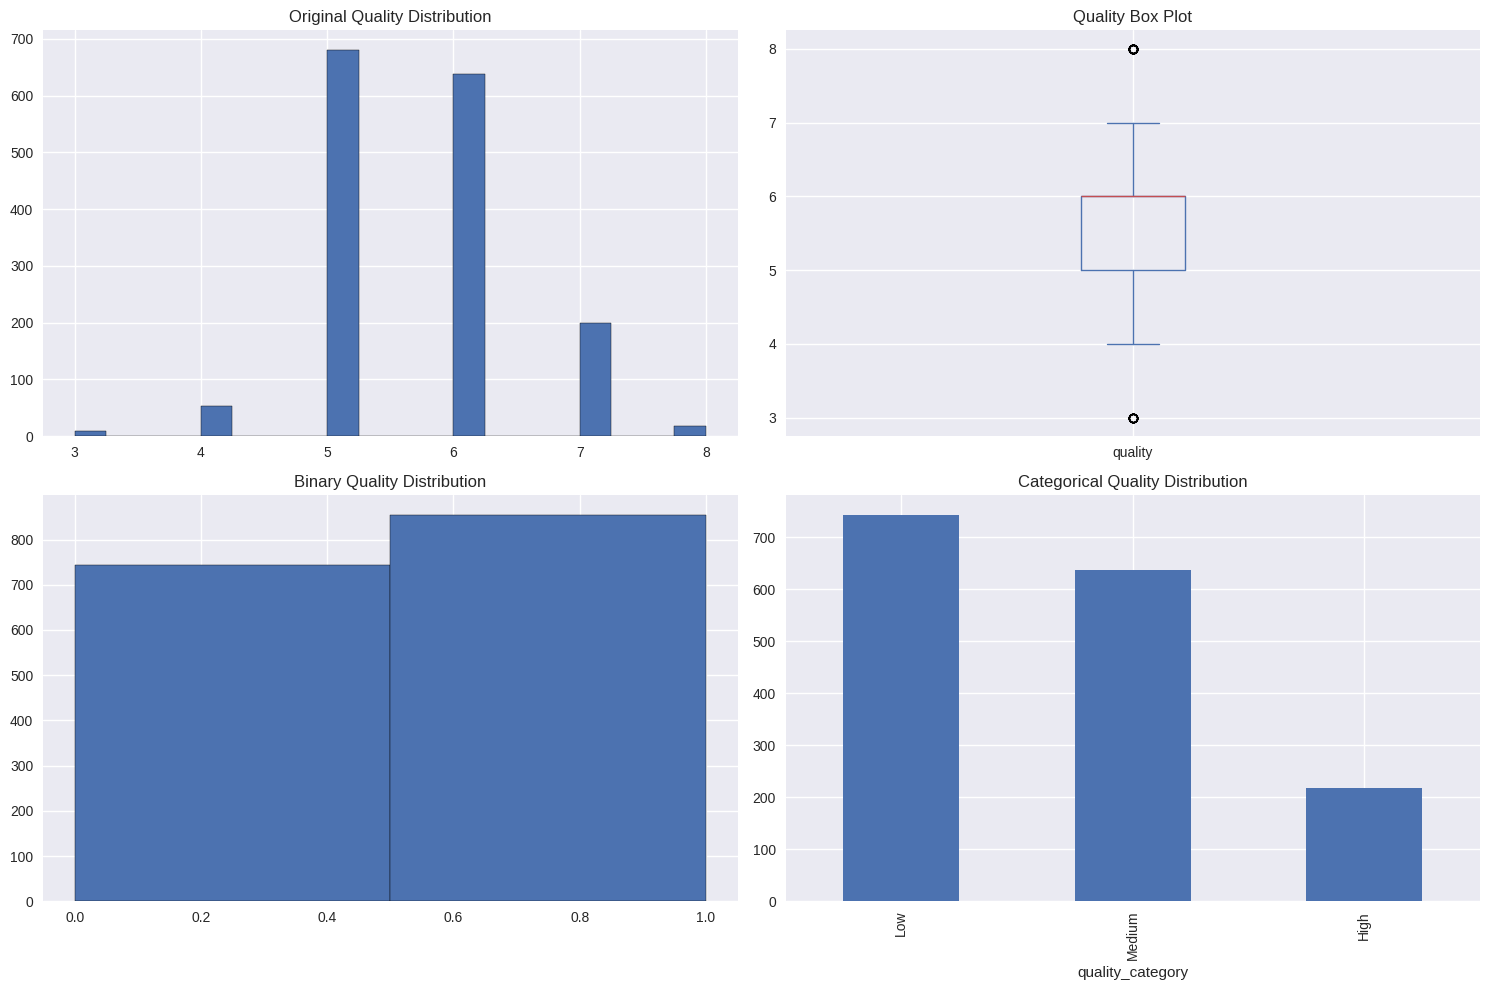

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
data['quality'].hist(bins=20, ax=axes[0,0], edgecolor='black')
axes[0,0].set_title('Original Quality Distribution')
data['quality'].plot(kind='box', ax=axes[0,1])
axes[0,1].set_title('Quality Box Plot')
data['quality_binary'] = (data['quality'] >= 6).astype(int)
data['quality_category'] = pd.cut(data['quality'], bins=[2, 5, 6, 8], labels=['Low', 'Medium', 'High'])
data['quality_binary'].hist(bins=2, ax=axes[1,0], edgecolor='black')
axes[1,0].set_title('Binary Quality Distribution')
data['quality_category'].value_counts().plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Categorical Quality Distribution')
plt.tight_layout()
plt.show()